1. Provide options which dataset/forest to load
2. Precompute maps and cable roads
3. Set A-Value, slope, etc.
4. Provide pre-computed optimized results
5. Editor
   - top layout
   - Pareto frontier
   - Current layout properties
6. Export? to exact positions of tree


In [7]:
# Package Imports
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon, Point

# to load the interactive plotting version
# %matplotlib widget
# or regular
# %matplotlib inline
# %gui qt

# Importing my modules
# from src.main import data_loading, plotting_2d

In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
# set up a variable store
# backup = pd.HDFStore('backup.h5')

# backup['var1'] = var1

# At the end, probably a good idea to do
# backup.close()

# and to continue
# backup = pd.HDFStore('backup.h5')
# var1 = backup['var1']

#### Preprocessing


In [37]:
# Load, preprocess and save the dataframe with the corresponding number - only needed to do once
data_loading.load_and_preprocess_raw_data(data_to_load=3)

In [38]:
tree_gdf, height_gdf = data_loading.load_processed_gdfs(data_to_load=3)

In [39]:
len(tree_gdf)

633

#### Area-Specific Setup


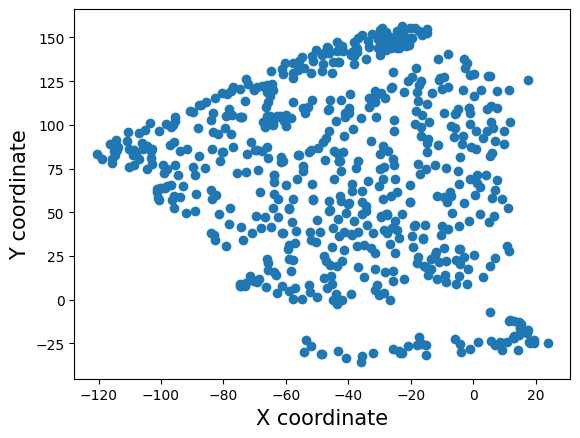

In [40]:
# create coordinates for each dataframe with the corresponding upper and lower anchors
coords = []
fig, ax = plt.subplots()
ax.set_xlabel("X coordinate", fontsize=15)
ax.set_ylabel("Y coordinate", fontsize=15)
ax.scatter(tree_gdf["x"], tree_gdf["y"])

cid = fig.canvas.mpl_connect(
    "button_press_event", lambda event: plotting_2d.onclick(event, coords)
)

In [42]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon(
    [
        Point(xy)
        for xy in [
            (-123.88268627035482, 83.05479790035122),
            (-74.89307684787903, 138.5299549848453),
            (-21.10056454084676, 161.97821725767267),
            (-6.051468835903222, 148.2524051955298),
            (-60.16417466857257, 116.79741921978575),
            (-115.23746107815322, 64.75371515082742),
        ]
    ]
)
uphill_anchors = Polygon(
    [
        Point(xy)
        for xy in [
            (-55.04107825837903, -15.31352187833928),
            (-17.578435758838708, -17.601157222029755),
            (4.194723984483858, -1.5877098161964227),
            (30.450593086725803, -30.18315161232738),
            (-11.49475877173387, -41.04941949485714),
            (-58.5632070403871, -38.189875315244045),
        ]
    ]
)
# road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
# road = LineString([(-59.52378761729838, -12.453977698726185), (-41.91314370725806, -13.597795370571419), (-18.218822810112897, -10.16634235503571), (3.2341434075725886, 0.12801669157144602), (15.401497381782264, 23.576278964398824), (17.00246500996775, 26.43582314401192)])
road = LineString(
    [
        (-89.6286010742188, -24.4624996185303),
        (-69.618896484375, -20.364200592041),
        (-41.314998626709, -13.9251003265381),
        (-29.2644004821777, -8.47910022735596),
        (-20.2950000762939, -3.67030000686646),
        (-15.375, -0.148599997162819),
        (-6.49030017852783, 2.74860000610352),
        (0.943400025367737, 3.86450004577637),
        (15.1605997085571, -0.302300006151199),
        (29.3377990722656, -3.47709989547729),
    ]
)

inner_forest = Polygon(
    [
        Point(xy)
        for xy in [
            (-105.43005197808363, 62.73802056488026),
            (-10.557896233758669, 146.34023494632802),
            (13.160142702322588, 51.07259530235265),
            (8.890895693827957, 9.27148811162877),
            (-55.62217021231302, -10.17088732591722),
            (-81.71201304200238, 18.992675830401765),
        ]
    ]
)

extra_geometry_gpd = gpd.GeoDataFrame(
    pd.DataFrame(
        {
            "name": ["uphill_anchors", "road", "downhill_anchors", "inner_forest"],
            "geometry": [uphill_anchors, road, downhill_anchors, inner_forest],
        }
    )
)

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace=True)
extra_geometry_gpd.loc["road"]

# plotting.plot_gdfs([tree_gdf,extra_geometry_gpd])

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


geometry    LINESTRING (-89.62860 -24.46250, -69.61890 -20...
Name: road, dtype: geometry

In [43]:
from src.main import classes_cable_road_computation

# create a class instance of the forest area with all the necessary attributes
forest_area_3 = classes_cable_road_computation.forest_area(
    tree_gdf, height_gdf, extra_geometry_gpd
)

In [44]:
%store forest_area_3

Stored 'forest_area_3' (forest_area)


#### Compute the cable roads


In [53]:
forest_area_3.compute_cable_road()

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2304  candidates initially
2278  after slope deviations


KeyboardInterrupt: 

In [56]:
forest_area_3.compute_line_costs()

In [52]:
# %store forest_area_3

Stored 'forest_area_3' (forest_area)


In [3]:
%store -r forest_area_3

no stored variable or alias forest_area_3


#### Create the optimization


In [60]:
from src.main import optimization_execution


def optimization_main_loop(forest_area_gdf):
    """Main loop for the optimization algorithm"""

    optimization_result_list = []
    model_list = []

    # first the basis optimization
    print("Starting basis optimization")
    # (
    #     model_list,
    #     optimization_result_list,
    # ) = optimization_execution.soo_optimization_augmecon(
    #     model_list, optimization_result_list, forest_area_gdf
    # )

    # then the manual weights optimization
    print("Starting manual weights optimization")
    optimization_result_list = optimization_execution.soo_optimization_manual_weights(
        model_list, optimization_result_list, forest_area_gdf
    )

    # then the NSGA II optimization
    print("Starting NSGA II optimization")
    optimization_result_list = optimization_execution.nsga_optimization(
        model_list, optimization_result_list, forest_area_gdf
    )

    # create a result df to save the results
    results_df = optimization_execution.create_results_df(
        optimization_result_list, model_list[0], forest_area_gdf
    )

    # # create ranges for the different objectives based on the results
    # (
    #     ecological_range,
    #     ecological_step,
    #     ergonomics_range,
    #     ergonomics_step,
    # ) = optimization_execution.compute_augmecon_ranges(results_df)

    # # conduct the augmecon optimization
    # print("Starting augmecon optimization")
    # optimization_result_list = optimization_execution.augmecon_optimization(
    #     optimization_result_list,
    #     ecological_range,
    #     ecological_step,
    #     ergonomics_range,
    #     ergonomics_step,
    #     forest_area_gdf,
    # )

    # and finally the expert layout optimization
    print("Starting expert layout optimization")
    optimization_result_list = optimization_execution.expert_layout_optimization(
        optimization_result_list, model_list[0], forest_area_gdf
    )

    # and final result list
    results_df = optimization_execution.create_results_df(
        optimization_result_list, model_list[0], forest_area_gdf
    )

    return results_df, optimization_result_list, model_list


results_df, optimization_result_list, model_list = optimization_main_loop(forest_area_3)

Starting basis optimization
Starting manual weights optimization


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


test
Starting NSGA II optimization


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/main/classes_mo_optimization.py:425: RuntimeWarning: overflow encountered in exp
  metroplis_criterion = np.exp(


Profit baseline is 60561.43259970596
Starting expert layout optimization
Profit baseline is 58597.59376380608


In [91]:
results_df = optimization_execution.create_results_df(
    optimization_result_list[0:4], model_list[0], forest_area_3
)

Profit baseline is 60561.43259970596


#### Plotting


In [62]:
results_df.columns

Index(['Total distance of trees to cable roads',
       'Productivity cost per m3 as per Stampfer',
       'Total distance from carriage to support', 'overall_profit',
       'cable_road_costs', 'profit_comparison', 'name', 'cost_objective',
       'ecological_distances', 'ergonomics_distances',
       'ecological_distances_RNI', 'ergonomics_distances_RNI',
       'cost_objective_RNI'],
      dtype='object')

In [81]:
import plotly.graph_objects as go
from ipywidgets import VBox, HBox
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np

from random import random

from src.main import geometry_operations


def plot_pareto_frontier(forest_area_gdf, optimization_result_list):
    pareto_frontier = go.FigureWidget(
        go.Scatter3d(
            x=results_df["ecological_distances_RNI"],
            y=results_df["ergonomics_distances_RNI"],
            z=results_df["cost_objective_RNI"],
        )
    )

    pareto_frontier.update_layout(
        width=1200,
        height=800,
        title="Pareto Frontier",
        xaxis_title="Ecological RNI",
        yaxis_title="Ergonomics RNI",
        scene_zaxis_title="Cost RNI",
    )

    layout_plot = go.FigureWidget([])

    def selection_fn(trace, points, selector):
        # get index of this point in the trace
        index = points.point_inds[0]

        # update the layout plot to show this result
        layout_plot.data = []
        #
        layout_plot.add_traces(
            list(
                plotting_2d.plot_optimization_layout(
                    optimization_result_list[index],
                    forest_area_gdf.line_gdf,
                    forest_area_gdf.harvesteable_trees_gdf,
                ).data
            )
        )

        layout_plot.update_layout(title=optimization_result_list[index].name)

    layout_plot.update_layout(width=1200, height=800)
    pareto_frontier.data[0].on_click(selection_fn)
    return pareto_frontier, layout_plot

In [84]:
results_df

,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,cost_objective,ecological_distances,ergonomics_distances,ecological_distances_RNI,ergonomics_distances_RNI,cost_objective_RNI
0,4632.428316,3471.303308,44709.991197,60561.432600,2327.585597,1963.838836,model,5798.888904,808.272015,486.835568,100,100,90
1,4374.602501,3066.146851,44687.836702,61095.951349,2198.223304,2498.357585,NSGA2 5,5264.370155,913.019832,560.754023,88,86,100
2,4308.887986,3075.418656,44767.343966,61079.284925,2205.617923,2481.691161,NSGA2 3,5281.036579,892.092887,571.264720,90,85,99
3,4284.683290,3102.712327,44966.744819,61045.938013,2211.671164,2448.344249,NSGA2 1,5314.383491,864.987791,565.364754,93,86,99
4,4292.512876,3045.435675,44864.238518,60957.505183,2357.380646,2359.911419,NSGA2 0,5402.816321,826.461413,517.335138,97,94,97
5,4326.177270,3086.094316,44957.672802,61063.325906,2210.901282,2465.732142,NSGA2 6,5296.995598,890.747521,596.232206,90,81,99
6,7927.307317,4391.432199,45421.926804,58597.593764,3371.295541,0.000000,"expert_layout_[30, 37]",7762.727740,3585.915930,4186.745424,22,11,67
7,5285.048891,4237.917122,45026.320343,59221.248731,2901.155651,623.654967,"expert_layout_[32, 59, 71]",7139.072773,1494.122274,1183.797519,54,41,73


In [83]:
def plot_pareto_frontier(results_df):
    pareto_frontier = go.FigureWidget(
        go.Scatter3d(
            x=results_df["ecological_distances_RNI"],
            y=results_df["ergonomics_distances_RNI"],
            z=results_df["cost_objective_RNI"],
        )
    )

    return pareto_frontier


def add_pareto_onclick_function(pareto_frontier, interactive_layout, results_df):
    def selection_fn(trace, points, selector):
        # get index of this point in the trace
        index = points.point_inds[0]

        # this probably happens repeatedly, I want to do this only once?
        # first set all traces to lightgrey, ie deactivated:
        interactive_layout.update_traces(line=dict(color="lightgrey"))

        # get the corresponding list of activated cable rows from the dataframe
        index = points.point_inds[0]
        active_rows = results_df.iloc[index]["selected_lines"]
        for active_row in active_rows:
            # then, set the traces at the indices of the selected pareto option to black
            interactive_layout.update_traces(
                line=dict(color="black"), selector={"name": active_row}
            )

        layout_plot.update_layout(title=results_df.iloc[index].name)

    layout_plot.update_layout(width=1200, height=800)
    pareto_frontier.data[0].on_click(selection_fn)

    return pareto_frontier


def interactive_cr_selection(
    forest_area_gdf, model_list, optimization_result_list, results_df
):
    # get the pareto frontier as 3d scatter plot
    pareto_frontier = plot_pareto_frontier(results_df)

    # create a trace for the trees
    xs, ys = zip(
        *[
            (row.xy[0][0], row.xy[1][0])
            for row in forest_area_gdf.harvesteable_trees_gdf.geometry
        ]
    )
    trees = go.Scatter(
        x=xs,
        y=ys,
        mode="markers",
        marker=dict(color="green"),
        name="trees",
    )

    # Create traces for each line
    individual_lines = [
        go.Scatter(
            x=np.asarray(row.geometry.xy[0]) + random(),
            y=np.asarray(row.geometry.xy[1]) + random(),
            mode="lines",
            line=dict(color="lightgrey"),
            name=str(id),
        )
        for id, row in forest_area_gdf.line_gdf.iterrows()
    ]

    # create a figure from all individual scatter lines
    interactive_layout = go.FigureWidget([*individual_lines, trees])
    interactive_layout.update_layout(
        width=1000,
        height=800,
    )

    # create the onclick function to select new CRs
    def selection_fn(trace, points, selector):
        # since the handler is activated for all lines, test if this one has coordinates, ie. is the clicked line
        print(points.xs)
        if points.xs:
            if trace.line.color == "black":
                interactive_layout.update_traces(
                    line=dict(color="lightgrey"), selector={"name": trace.name}
                )
            elif trace.line.color == "lightgrey":
                # update this trace to turn black
                interactive_layout.update_traces(
                    line=dict(color="black"), selector={"name": trace.name}
                )

            # get all active traces
            active_traces = interactive_layout.select_traces(
                selector={"line.color": "black"}
            )
            active_traces_names = [int(trace.name) for trace in active_traces]
            print(active_traces_names)
            # set the dataframe rows to show only these CRs
            t.data[0].cells.values = [df[df.index.isin(active_traces_names)]]

            # and update the dataframe showing the computed costs
            c.data[0].cells.values = update_layout_cost_df(active_traces_names)

    # add the onclick function to all traces
    for trace in interactive_layout.data:
        trace.on_click(selection_fn)

    # create a dataframe and push it to a figurewidget to display details about our selected lines
    df = forest_area_gdf.line_gdf[["line_cost", "line_length"]]
    line_cost_table = go.FigureWidget(
        [go.Table(header=dict(values=df.columns), cells=dict(values=[df]))]
    )

    cost_gdf = pd.DataFrame(
        columns=["Tree_to_line_distance", "Productivity_cost", "Line_cost", "Profit"]
    )
    distances_table = go.FigureWidget(
        [go.Table(header=dict(values=cost_gdf.columns), cells=dict(values=[cost_gdf]))]
    )

    def update_layout_cost_df(indices):
        """
        Function to update the cost dataframe with the new indices based on the selected lines
        """

        rot_line_gdf = forest_area_gdf.line_gdf[
            forest_area_gdf.line_gdf.index.isin(indices)
        ]

        # Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
        (
            distance_tree_line,
            distance_carriage_support,
        ) = geometry_operations.compute_distances_facilities_clients(
            forest_area_gdf.harvesteable_trees_gdf, rot_line_gdf
        )

        # assign all trees to their closest line
        try:
            tree_to_line_assignment = np.argmin(distance_tree_line, axis=1)

            # compute the distance of each tree to its assigned line
            distance_trees_to_lines = sum(
                distance_tree_line[
                    range(len(tree_to_line_assignment)), tree_to_line_assignment
                ]
            )
        except:
            tree_to_line_assignment = [1 for i in range(len(distance_tree_line))]
            distance_trees_to_lines = sum(distance_tree_line)

        # compute the productivity cost
        productivity_cost_overall = np.sum(
            model_list[0].productivity_cost[
                range(len(tree_to_line_assignment)), tree_to_line_assignment
            ]
        )

        line_cost = sum(rot_line_gdf["line_cost"])
        return [
            distance_trees_to_lines,
            productivity_cost_overall,
            line_cost,
            63025 - productivity_cost_overall,
            tree_to_line_assignment,
        ]

    # Put everything together in a VBox
    return interactive_layout, line_cost_table, distances_table


interactive_layout, line_cost_table, distances_table = interactive_cr_selection(
    forest_area_3, model_list, optimization_result_list
)
pareto_frontier, layout_plot = plot_pareto_frontier(
    forest_area_3, optimization_result_list
)

VBox(
    [
        HBox([pareto_frontier, layout_plot]),
        HBox([interactive_layout, line_cost_table, distances_table]),
    ]
)

    'data': [{'type': 'scatter3d',
              'uid': '51d6143a…